# Network Analysis with BigQuery
## Bachelor Thesis Data Analysis

This notebook contains templates and utilities for analyzing social network data stored in BigQuery.

In [1]:
# Enable inline plotting
%matplotlib inline

In [21]:
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/calvindudek/projects/sophie/twitter-analysis-python/.secrets/service-account.json'

creds_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
print(f"Current credentials path: {creds_path}")

Current credentials path: /Users/calvindudek/projects/sophie/twitter-analysis-python/.secrets/service-account.json


## 1. Setup and Configuration

Import libraries and set up BigQuery connections.

In [22]:
# Data handling and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BigQuery
from google.cloud import bigquery
from google.cloud.exceptions import GoogleCloudError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Define colors
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
sns.set_palette(sns.color_palette(colors))

In [23]:
# BigQuery configuration
project_id = "grounded-nebula-408412"
dataset = "python_src"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

## 2. BigQuery Utilities

This section includes utility functions for working with BigQuery:
- List all tables in the dataset
- Retrieve the schema of a specific table

In [24]:
def list_tables():
    """List all tables in the dataset."""
    try:
        dataset_ref = client.dataset(dataset)
        tables = list(client.list_tables(dataset_ref))
        table_names = [table.table_id for table in tables]
        print("Tables in dataset:")
        for table in table_names:
            print(f"- {table}")
    except GoogleCloudError as e:
        print(f"Error listing tables: {str(e)}")

In [25]:
def get_table_schema(table_id):
    """Retrieve the schema of a given BigQuery table."""
    try:
        table_ref = client.dataset(dataset).table(table_id)
        table = client.get_table(table_ref)
        schema_df = pd.DataFrame([
            {"Column Name": field.name, "Data Type": field.field_type, "Mode": field.mode}
            for field in table.schema
        ])
        return schema_df
    except GoogleCloudError as e:
        print(f"Error fetching schema: {str(e)}")
        return pd.DataFrame()

### Example Usage

To list all tables in the dataset:
```python
list_tables()
```

To get the schema of a specific table:
```python
get_table_schema('your_table_name')
```

## 3. Query Execution Function

In [28]:
def run_query(query, use_cache=True):
    """Execute a BigQuery query and return results as a DataFrame."""
    try:
        # Configure the query job to use cache if requested
        job_config = bigquery.QueryJobConfig(use_query_cache=use_cache)

        # Execute the query
        query_job = client.query(query, job_config=job_config)

        # Convert to DataFrame without using the BigQuery Storage API
        results_df = query_job.to_dataframe(create_bqstorage_client=False)

        # Print information about the results
        print(f"Query executed successfully. Retrieved {len(results_df)} rows.")
        if len(results_df) > 0:
            print(f"Columns: {list(results_df.columns)}")
        else:
            print("Warning: Query returned no results.")

        return results_df

    except Exception as e:
        print(f"Error executing query: {str(e)}")
        # Return an empty DataFrame so code can continue without errors
        return pd.DataFrame()

## 4. Network Size Visualization

Query executed successfully. Retrieved 60 rows.
Columns: ['month_start_str', 'node_id', 'toxicity_sent_avg', 'toxicity_received_avg']


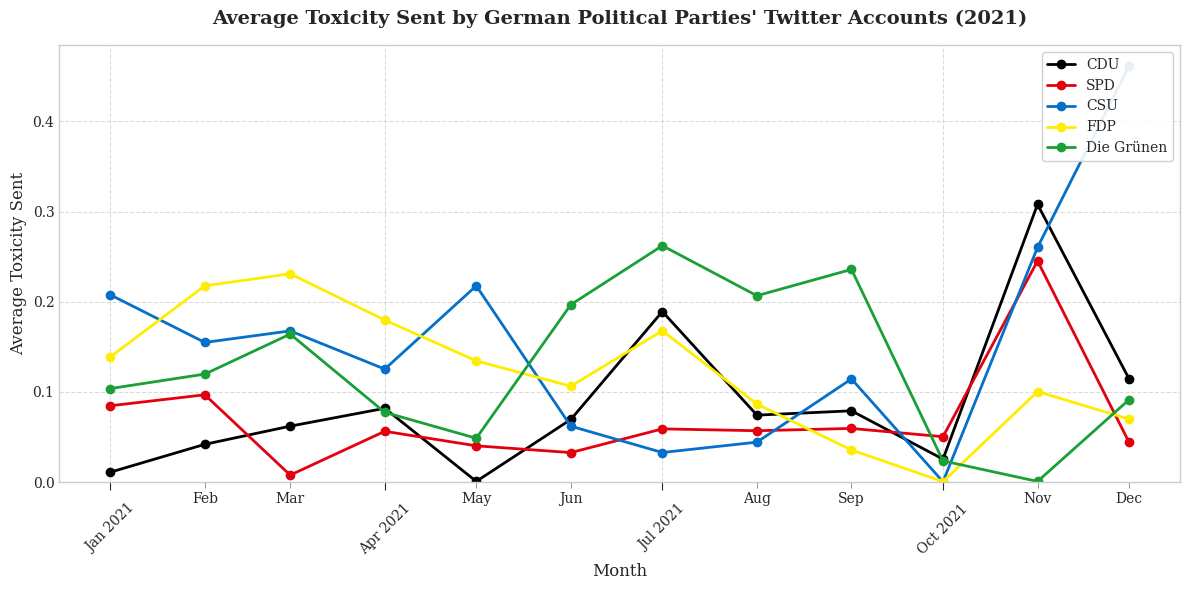

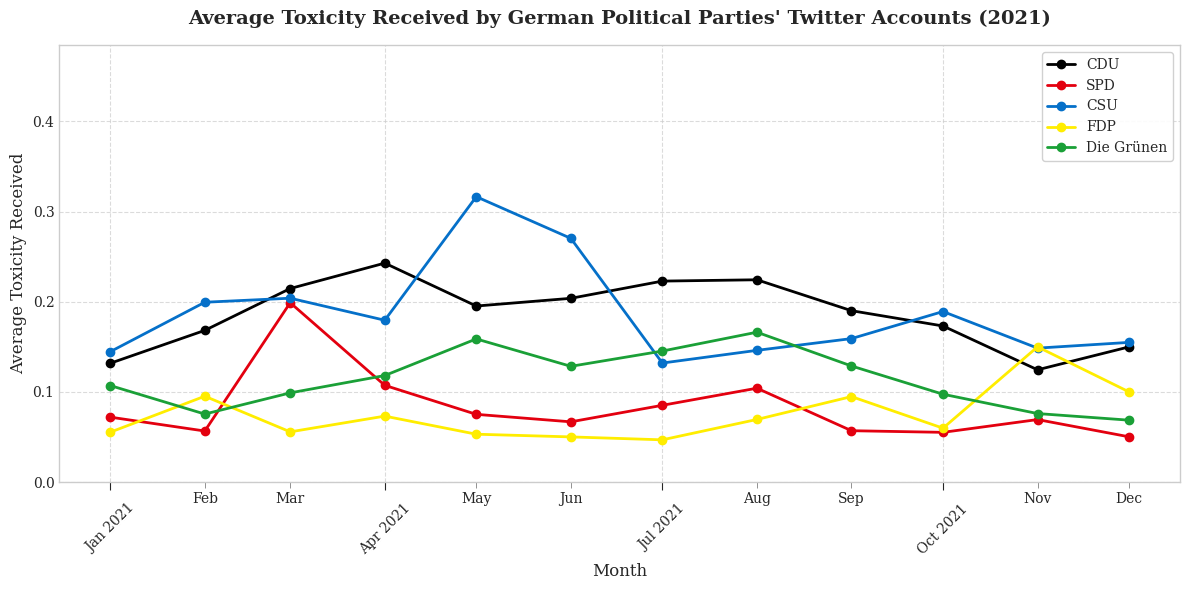

In [36]:
# Query toxicity metrics for specific German political party accounts for 2021 only
party_toxicity_query = f"""
SELECT 
    CAST(month_start AS STRING) as month_start_str,
    node_id,
    toxicity_sent_avg,
    toxicity_received_avg
FROM `grounded-nebula-408412.python_src.python_network_users_node_metrics`
WHERE node_id IN ('cdu', 'spdde', 'csu', 'fdp', 'die_gruenen')
  AND month_start >= '2021-01-01' 
  AND month_start < '2022-01-01'
ORDER BY month_start, node_id
"""

# Run the query
party_df = run_query(party_toxicity_query)

# Define colors for each party
party_colors = {
    "cdu": "#000000",  # Black for CDU
    "spdde": "#E3000F",  # Red for SPD
    "csu": "#0570C9",  # Blue for CSU
    "fdp": "#FFED00",  # Yellow for FDP
    "die_gruenen": "#1AA037",  # Green for Die Grünen
}

# Map party IDs to proper names
party_names = {
    "cdu": "CDU",
    "spdde": "SPD",
    "csu": "CSU",
    "fdp": "FDP",
    "die_gruenen": "Die Grünen",
}

# Check if we got data back
if len(party_df) == 0:
    print("No data returned from query. Check permissions and table content.")
else:
    # Check if required columns exist
    if "month_start_str" not in party_df.columns:
        print(
            f"Error: 'month_start_str' column not found. Available columns: {list(party_df.columns)}"
        )
    else:
        # Convert string date to datetime
        party_df["month_start"] = pd.to_datetime(party_df["month_start_str"])

        # Find the global maximum value for both metrics to standardize scales
        max_toxicity_sent = party_df["toxicity_sent_avg"].max()
        max_toxicity_received = party_df["toxicity_received_avg"].max()
        global_max = (
            max(max_toxicity_sent, max_toxicity_received) * 1.05
        )  # Add 5% margin

        # Create figure for toxicity sent
        fig, ax = plt.subplots(figsize=(12, 6))
        for party in ["cdu", "spdde", "csu", "fdp", "die_gruenen"]:
            party_data = party_df[party_df["node_id"] == party]
            if not party_data.empty:
                ax.plot(
                    party_data["month_start"],
                    party_data["toxicity_sent_avg"],
                    marker="o",
                    linewidth=2,
                    color=party_colors.get(party),
                    label=party_names.get(party, party),  # Use proper names
                )
            else:
                print(f"No data found for party: {party}")

        # Set up better title with proper formatting
        ax.set_title(
            "Average Toxicity Sent by German Political Parties' Twitter Accounts (2021)",
            fontsize=14,
            fontweight="bold",
            pad=15,
        )

        ax.set_xlabel("Month", fontsize=12)
        ax.set_ylabel("Average Toxicity Sent", fontsize=12)

        # Set up legend with proper formatting
        ax.legend(loc="upper right", frameon=True, framealpha=0.9, fontsize=10)

        ax.grid(True, linestyle="--", alpha=0.7)

        # Set up major and minor tick marks
        import matplotlib.dates as mdates

        # Major ticks every quarter
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

        # Minor ticks every month
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

        # Customize minor tick marks
        ax.tick_params(axis="x", which="minor", length=4, color="gray")
        ax.tick_params(axis="x", which="major", length=6, pad=8)

        ax.set_ylim(0, global_max)  # Set y-axis to start at 0 and end at global max
        plt.xticks(rotation=45)
        ax.tick_params(top=False)  # Remove top ticks
        ax.tick_params(right=False)  # Remove right ticks
        plt.tight_layout()
        plt.show()

        # Create figure for toxicity received
        fig, ax = plt.subplots(figsize=(12, 6))
        for party in ["cdu", "spdde", "csu", "fdp", "die_gruenen"]:
            party_data = party_df[party_df["node_id"] == party]
            if not party_data.empty:
                ax.plot(
                    party_data["month_start"],
                    party_data["toxicity_received_avg"],
                    marker="o",
                    linewidth=2,
                    color=party_colors.get(party),
                    label=party_names.get(party, party),  # Use proper names
                )
            else:
                print(f"No data found for party: {party}")

        # Set up better title with proper formatting
        ax.set_title(
            "Average Toxicity Received by German Political Parties' Twitter Accounts (2021)",
            fontsize=14,
            fontweight="bold",
            pad=15,
        )

        ax.set_xlabel("Month", fontsize=12)
        ax.set_ylabel("Average Toxicity Received", fontsize=12)

        # Set up legend with proper formatting
        ax.legend(loc="upper right", frameon=True, framealpha=0.9, fontsize=10)

        ax.grid(True, linestyle="--", alpha=0.7)

        # Set up major and minor tick marks
        # Major ticks every quarter
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

        # Minor ticks every month
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

        # Customize minor tick marks
        ax.tick_params(axis="x", which="minor", length=4, color="gray")
        ax.tick_params(axis="x", which="major", length=6, pad=8)

        ax.set_ylim(0, global_max)  # Set y-axis to start at 0 and end at global max
        plt.xticks(rotation=45)
        ax.tick_params(top=False)  # Remove top ticks
        ax.tick_params(right=False)  # Remove right ticks
        plt.tight_layout()
        plt.show()